# Dogs vs Cats with Transfer Learning and Data Augmentation

In this Notebook we're going to use transfer learning to attempt to crack the [Dogs vs Cats Kaggle competition](https://www.kaggle.com/c/dogs-vs-cats).

We add data augmentation and assess its effectiveness.

We are going to downsample the images to 64x64; that's pretty small, but should be enough (I hope). Furthermore, large images means longer training time and I'm too impatient for that. ;)

## *--- Changes for data augmentation ---*

The modifications to the code for data augmentation are marked in blocks with italic headings.

Lets have plots appear inline:

In [1]:
%matplotlib inline

We're going to need `os`, `numpy`, `matplotlib`, `skimage`, `theano` and `lasagne`. We also want to import some layer classes and utilities from Lasagne for convenience.

In [2]:
import os, time, glob, tqdm
import numpy as np
from matplotlib import pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision
import skimage.transform, skimage.util
from skimage.util import montage
from sklearn.model_selection import StratifiedShuffleSplit
import cv2
from batchup import work_pool, data_source

import utils
import imagenet_classes

torch_device = torch.device('cuda:0')

## Data loading

We are loading images from a folder of files, so we could approach this a number of ways.

Our dataset consists of 25,000 images so we could load them all into memory then access them from there. It would work, but it wouldn't scale. I'd prefer to demonstrate an approach that is more scalable and useful outside of this notebook, so we are going to load them on the fly.

Loading images on the fly poses a challenge as we may find that the GPU is waiting doing nothing while the CPU is loading images in order to build the next mini-batch to train with. It would therefore be desirable to load images in background threads so that mini-batches of images are ready to process when the GPU is able to take one. Luckily my [`batchup`](http://github.com/Britefury/batchup) library can help here.

We must provide the logic for:

- getting a list of paths where we can find the image files
- given a list of indices identifying the images that are to make up this mini-batch, for each image in the mini-batch:
  - load each one
  - scale each one to the fixed size that we need
  - standardise each image (subtract mean, divide by standard deviation)
- gather them in a mini-batch of shape `(sample, channel, height, width)`

## Getting a list of paths where we can find the image files

Join the [Kaggle competition](https://www.kaggle.com/c/dogs-vs-cats) and download the training and test data sets. Unzip them into a directory of your choosing, and modify the path definitions below to point to the appropriate location.

We split the images into training and validation later on, so we call them `trainval` for now.

In [3]:
TRAIN_PATH = r'E:\datasets\dogsvscats\train'
TEST_PATH = r'E:\datasets\dogsvscats\test1'

# Get the paths of the images
trainval_image_paths = glob.glob(os.path.join(TRAIN_PATH, '*.jpg'))
tests_image_paths = glob.glob(os.path.join(TEST_PATH, '*.jpg'))

Okay. We have our image paths. Now we need to create our ground truths. Luckily the filename of each file starts with either `cat.` or `dog.` indicating which it is. We will assign dogs a class of `1` and cats a class of `0`.

In [4]:
# The ground truth classifications are given by the filename having either a 'dog.' or 'cat.' prefix
# Use:
# 0: cat
# 1: dog
trainval_y = [(1 if os.path.basename(p).lower().startswith('dog.') else 0) for p in trainval_image_paths]
trainval_y = np.array(trainval_y).astype(np.int32)

## Split into training and validation

We use Scikit-Learn `StratifiedShuffleSplit` for this.

In [5]:
# We only want one split, with 10% of the data for validation
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=12345)

# Get the training set and validation set sample indices
train_ndx, val_ndx = next(splitter.split(trainval_y, trainval_y))

print('{} training, {} validation'.format(len(train_ndx), len(val_ndx)))

22500 training, 2500 validation


## Define a function for loading a mini-batch of images

Given a list of indices into the `train_image_paths` list we must:

- load each one
- scale each one to the fixed size that we need
- standardise each image (subtract mean, divide by standard deviation)

## *<< ONE SMALL CHANGE HERE >>*

One change here; we scale to a fixed size of `80x80` rather than `64x64` so that we can randomly crop `64x64` regions in a data augmentation function.

In [6]:
MODEL_MEAN = np.array([0.485, 0.456, 0.406])
MODEL_STD = np.array([0.229, 0.224, 0.225])
TARGET_SIZE = 80

def img_to_net(img):
    """
    Convert an image from
    image format; shape (height, width, channel) range [0-1]
    to
    network format; shape (channel, height, width), standardised by mean MODEL_MEAN and std-dev MODEL_STD
    """
    # (H, W, C) -> (C, H, W)
    img = (img - MODEL_MEAN) / MODEL_STD
    img = img.transpose(2, 0, 1)
    return img.astype(np.float32)

def net_to_img(img):
    """
    Convert an image from
    network format; shape (sample, channel, height, width), standardised by mean MODEL_MEAN and std-dev MODEL_STD
    to
    image format; shape (height, width, channel) range [0-1]
    """
    # (C, H, W) -> (H, W, C)
    img = img.transpose(1, 2, 0)
    img = img * MODEL_STD + MODEL_MEAN
    return img.astype(np.float32)

def load_image(path):
    """
    Load an image from a given path and convert to network format (4D tensor)
    """
    # Read
    img = cv2.imread(path)
    # OpenCV loads images in BGR channel order; reverse to RGB
    img = img[:, :, ::-1]
    
    # Compute scaled dimensions, while preserving aspect ratio
    # py0, py1, px0, px1 are the padding required to get the image to `TARGET_SIZE` x `TARGET_SIZE`
    if img.shape[0] >= img.shape[1]:
        height = TARGET_SIZE
        width = int(img.shape[1] * float(TARGET_SIZE) / float(img.shape[0]) + 0.5)
        py0 = py1 = 0
        px0 = (TARGET_SIZE - width) // 2
        px1 = (TARGET_SIZE - width) - px0
    else:
        width = TARGET_SIZE
        height = int(img.shape[0] * float(TARGET_SIZE) / float(img.shape[1]) + 0.5)
        px0 = px1 = 0
        py0 = (TARGET_SIZE - height) // 2
        py1 = (TARGET_SIZE - height) - py0
    # Resize the image using OpenCV resize
    # We use OpenCV as it is fast
    # We also resize *before* converting from uint8 type to float type as uint8 is significantly faster
    img = cv2.resize(img, (width, height))
    
    # Convert to float
    img = skimage.util.img_as_float(img)

    # Convert to network format
    img = img_to_net(img)
    
    # Apply padding to get it to a fixed size
    img = np.pad(img, [(0, 0), (py0, py1), (px0, px1)], mode='constant')
    
    return img



Show an image to check our code so far:

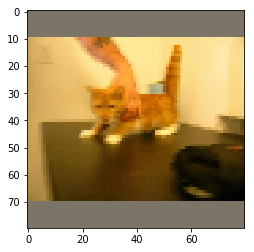

In [7]:
plt.imshow(net_to_img(load_image(trainval_image_paths[0])))
plt.show()

Looks okay.

## Make a BatchUp data source

BatchUp can extract mini-batches from data sources that have an array-like interface.

We must first define an image accessor that *looks like* an array. We do this by implementing `__len__` and `__getitem__` methods:

In [8]:
class ImageAccessor (object):
    def __init__(self, paths):
        """
        Constructor
        
        paths - the list of paths of the images that we are to access
        """
        self.paths = paths
        
    def __len__(self):
        """
        The length of this array
        """
        return len(self.paths)
    
    def __getitem__(self, item):
        """
        Get images identified by item
        
        item can be:
        - an index as an integer
        - an array of incies
        """
        if isinstance(item, int):
            # item is an integer; get a single item
            path = self.paths[item]
            return load_image(path)
        elif isinstance(item, np.ndarray):
            # item is an array of indices

            # Get the paths of the images in the mini-batch
            paths = [self.paths[i] for i in item]
            # Load each image
            images = [load_image(path) for path in paths]
            # Stack in axis 0 to make an array of shape `(sample, channel, height, width)`
            return np.stack(images, axis=0)

Now we make `ArrayDataSource` instances for the training and validation sets. These provide methods for getting mini-batches that we will use for training.

In [9]:
# image accessor
trainval_X = ImageAccessor(trainval_image_paths)

train_ds = data_source.ArrayDataSource([trainval_X, trainval_y], indices=train_ndx)
val_ds = data_source.ArrayDataSource([trainval_X, trainval_y], indices=val_ndx)

## *<< CHANGES START HERE >>*

## Data augmentation function

We now define a function to apply random data augmentation to a mini-batch of images.

In [10]:
def augment_train_batch(batch_X, batch_y):
    n = len(batch_X)
    
    # Random crop
    crop = np.random.randint(low=0, high=16, size=(n, 2))
    batch_X_cropped = np.zeros((n, 3, 64, 64), dtype=np.float32)
    for i in range(n):
        batch_X_cropped[i, :, :, :] = batch_X[i, :, crop[i, 0]:crop[i, 0]+64, crop[i, 1]:crop[i, 1]+64]
    batch_X = batch_X_cropped
    
    # Random horizontal flip
    flip_h = np.random.randint(low=0, high=2, size=(n,)) == 1
    batch_X[flip_h, :, :, :] = batch_X[flip_h, :, :, ::-1]
    
    # Random colour offset; normally distributed, std-dev 0.1
    colour_offset = np.random.normal(scale=0.1, size=(n, 3))
    
    batch_X += colour_offset[:, :, None, None]
    
    return batch_X, batch_y

Apply the augmentation function; the `map` method of the data source will pass each mini-batch through the provided function, in this case `augment_train_batch`. Note that the augmentation will also be performed in background threads.

In [11]:
train_ds = train_ds.map(augment_train_batch)

## *<< CHANGES END HERE >>*

#### Process mini-batches in background threads

We want to do all the image loading in background threads so that the images are ready for the main thread that must feed the GPU with data to work on.

BatchUp provides worker pools for this purpose.

In [12]:
# A pool with 4 threads
pool = work_pool.WorkerThreadPool(4)

Wrap our training and validation data sources so that they generate mini-batches in parallel background threads

In [13]:
train_ds = pool.parallel_data_source(train_ds)
val_ds = pool.parallel_data_source(val_ds)

## Build the network using the convolutional layers from VGG-16

Now we will define a class for the pet classifier network.

In [14]:
class XferPetClassifier (nn.Module):
    def __init__(self, pretrained_vgg16):
        super(XferPetClassifier, self).__init__()
        self.features = pretrained_vgg16.features
        
        # Size at this point will be 512 channels, 2x2
        
        self.fc6 = nn.Linear(512 * 2 * 2, 256)
        self.drop = nn.Dropout()
        self.fc7 = nn.Linear(256, 2)
        
    def forward(self, x):
        x = self.features(x)
        
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc6(x))
        x = self.drop(x)
        x = self.fc7(x)
        
        return x
        

In [15]:
# Build it
vgg16 = torchvision.models.vgg.vgg16(pretrained=True)

pet_net = XferPetClassifier(vgg16).to(torch_device)

## *Set up loss and optimizer*

We separate the pre-trained parameters from the new parameters. We train the pre-trained parameters using a learning rate that is 10 times smaller.

In [16]:
loss_function = nn.CrossEntropyLoss()

# Get a list of all of the parameters
all_params = list(pet_net.parameters())
# Get a list of pre-trained parameters
pretrained_params = list(pet_net.features.parameters())
# Get their IDs and use to get a list of new parameters
pretrained_param_ids = set([id(p) for p in pretrained_params])
new_params = [p   for p in all_params   if id(p) not in pretrained_param_ids]

# Build optimizer with separate learning rates for pre-trained and new parameters
optimizer = torch.optim.Adam([dict(params=new_params, lr=1e-3),
                              dict(params=pretrained_params, lr=1e-4)])

## Train the network

Define settings for training; note we only need 25 epochs here:

In [17]:
NUM_EPOCHS = 25
BATCH_SIZE = 128

The training loop:

In [18]:
print('Training...')

for epoch_i in range(NUM_EPOCHS):
    t1 = time.time()
    
    # TRAIN
    pet_net.train()
    train_loss = 0.0
    n_batches = 0
    # Ask train_ds for batches of size `BATCH_SIZE` and shuffled in random order
    for i, (batch_X, batch_y) in enumerate(train_ds.batch_iterator(batch_size=BATCH_SIZE, shuffle=True)):
        t_x = torch.tensor(batch_X, dtype=torch.float, device=torch_device)
        t_y = torch.tensor(batch_y, dtype=torch.long, device=torch_device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Predict logits
        pred_logits = pet_net(t_x)
        
        # Compute loss
        loss = loss_function(pred_logits, t_y)
        
        # Back-prop
        loss.backward()
        
        # Optimizer step
        optimizer.step()
        
        # Accumulate training loss
        train_loss += float(loss)
        n_batches += 1
    # Divide by number of samples to get mean loss
    train_loss /= float(n_batches)
    
    # VALIDATE
    pet_net.eval()
    val_loss = val_err = 0.0
    # For each batch:
    with torch.no_grad():
        for batch_X, batch_y in val_ds.batch_iterator(batch_size=BATCH_SIZE, shuffle=False):
            t_x = torch.tensor(batch_X, dtype=torch.float, device=torch_device)
            # Predict logits
            pred_logits = pet_net(t_x).detach().cpu().numpy()
            pred_cls = np.argmax(pred_logits, axis=1)
            val_err += (batch_y != pred_cls).sum()
    # Divide by number of samples to get mean loss and error
    val_err /= float(len(val_ndx))
    
    t2 = time.time()
    
    # REPORT
    print('Epoch {} took {:.2f}s: train loss={:.6f}; val err={:.2%}'.format(
            epoch_i, t2 - t1, train_loss, val_err))

Training...
Epoch 0 took 34.11s: train loss=0.185413; val err=4.60%
Epoch 1 took 31.04s: train loss=0.113306; val err=4.36%
Epoch 2 took 31.06s: train loss=0.088389; val err=5.88%
Epoch 3 took 34.40s: train loss=0.082190; val err=3.56%
Epoch 4 took 33.65s: train loss=0.058014; val err=3.52%
Epoch 5 took 33.31s: train loss=0.049849; val err=4.28%
Epoch 6 took 33.40s: train loss=0.046063; val err=3.56%
Epoch 7 took 33.67s: train loss=0.037511; val err=3.44%
Epoch 8 took 35.79s: train loss=0.033023; val err=3.40%
Epoch 9 took 39.43s: train loss=0.034194; val err=3.44%
Epoch 10 took 39.07s: train loss=0.027093; val err=3.76%
Epoch 11 took 36.67s: train loss=0.022012; val err=3.40%
Epoch 12 took 36.06s: train loss=0.022738; val err=3.92%
Epoch 13 took 36.30s: train loss=0.025338; val err=3.16%
Epoch 14 took 36.11s: train loss=0.018630; val err=2.72%
Epoch 15 took 36.00s: train loss=0.024132; val err=2.96%
Epoch 16 took 35.93s: train loss=0.018403; val err=3.92%
Epoch 17 took 35.73s: train l

### Apply to some example images from the test set

Sample 5950: predicted as dog, confidence 100.00%


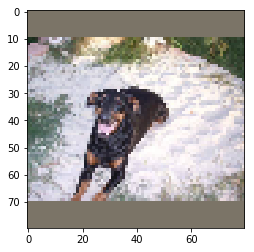

Sample 7880: predicted as cat, confidence 100.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


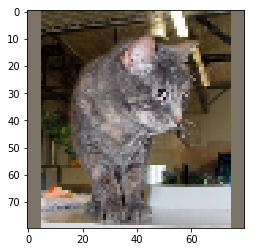

Sample 991: predicted as cat, confidence 97.51%


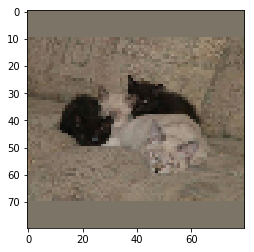

Sample 1626: predicted as dog, confidence 100.00%


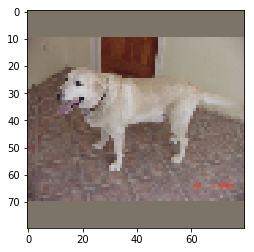

Sample 10303: predicted as cat, confidence 100.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


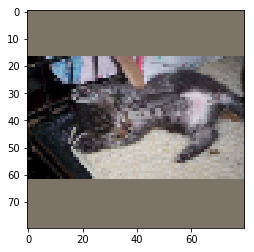

Sample 5411: predicted as cat, confidence 100.00%


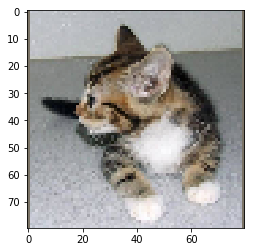

Sample 8916: predicted as dog, confidence 100.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


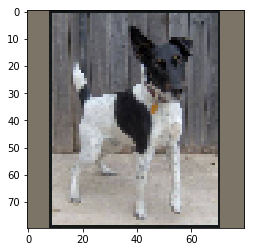

Sample 7664: predicted as cat, confidence 100.00%


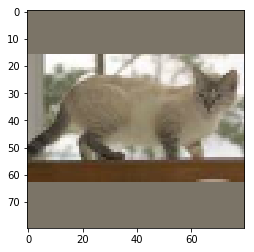

Sample 3207: predicted as dog, confidence 99.27%


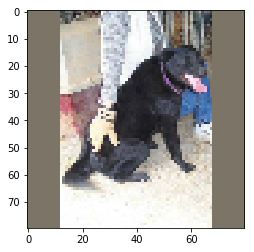

Sample 9140: predicted as cat, confidence 100.00%


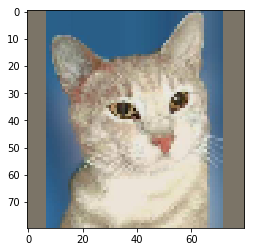

Sample 4274: predicted as cat, confidence 99.97%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


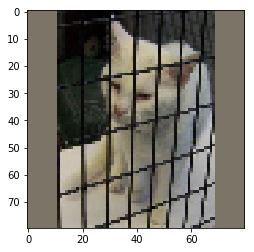

Sample 2407: predicted as cat, confidence 100.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


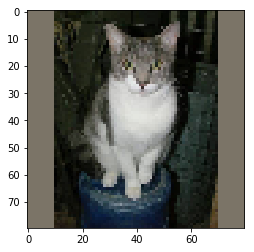

Sample 5028: predicted as dog, confidence 100.00%


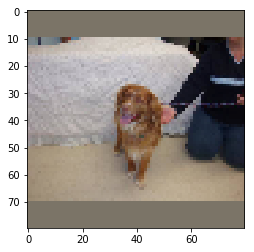

Sample 9156: predicted as cat, confidence 100.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


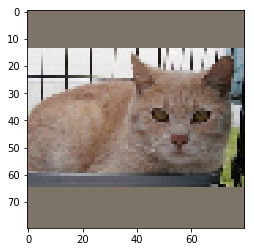

Sample 7149: predicted as cat, confidence 100.00%


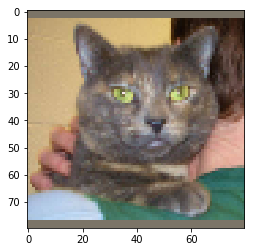

In [19]:
# Number of samples to try
N_TEST = 15

# Shuffle test sample indcies
rng = np.random.RandomState(12345)
test_ndx = rng.permutation(len(tests_image_paths))

# Select first `N_TEST` samples
test_ndx = test_ndx[:N_TEST]

for test_i in test_ndx:
    # Load the image
    X = load_image(tests_image_paths[test_i])
    
    with torch.no_grad():
        t_x = torch.tensor(X[None, ...], dtype=torch.float, device=torch_device)

        # Predict class probabilities
        pred_logits = pet_net(t_x)
        pred_prob = F.softmax(pred_logits, dim=1).detach().cpu().numpy()
    
    # Get predicted class
    pred_y = np.argmax(pred_prob, axis=1)

    # Get class name
    pred_cls = 'dog' if pred_y[0] == 1 else 'cat'

    # Report
    print('Sample {}: predicted as {}, confidence {:.2%}'.format(test_i, pred_cls, pred_prob[0,pred_y[0]]))
    # Show the image
    plt.figure()
    plt.imshow(net_to_img(X))
    plt.show()